# 10sec time slices, 80-20 every label

In [1]:

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from math import ceil
import timeit



time_slice = 10; #in seconds
num_labels = 3;
num_dfs_tot = 0
labels_dfs = [0]*num_labels

#to read multiple CSVs automatically
import glob
path = r'C:\Desktop stuff\university\camera captures\hik pcaps n CSVs' 
allFolderPaths = glob.glob(path + "/*")


#TODO: read all CSVs for label i, and cut 15 sec of start and end of each video. remove outliers.
for i in range(num_labels) :
    labels_dfs[i] = [pd.read_csv(f) for f in glob.glob(allFolderPaths[i] + "/*.csv")]
    num_dfs_tot += len(labels_dfs[i])

    for j in range(len(labels_dfs[i])) :
        labels_dfs[i][j] = labels_dfs[i][j][labels_dfs[i][j].Time > 15]
        labels_dfs[i][j] = labels_dfs[i][j][labels_dfs[i][j].Time < labels_dfs[i][j]["Time"].iloc[-1] - 15]
        labels_dfs[i][j]['Time'] -= 15
        labels_dfs[i][j]['Label'] = i

#%% rest

combined = pd.DataFrame()

seconds_in_DFs_list = [0]*num_dfs_tot #in a every single video dataframe
time_slice_list     = [0]*num_dfs_tot #initiallization
indexes_to_split_frame_by_list = [0]*num_dfs_tot #initiallization
time_sliced_df_list = []


start = timeit.default_timer() #to measure runtime

for k in range(num_labels) : #slice data frames by time slice seconds
    for i in list(range(len(labels_dfs[k]))) : #slice data frames by time slice seconds
        #"lose" non essential data
       labels_dfs[k][i].drop(['Source' , 'Destination' , 'Protocol' , 'Info' , 'No.'], axis=1, inplace=True)
       labels_dfs[k][i]['Time']  = labels_dfs[k][i]['Time'].astype('float') #change Time column data to int type 
       combined = combined.append(labels_dfs[k][i])
       
       seconds_in_DFs_list[i] = int(ceil(labels_dfs[k][i].at[len(labels_dfs[k][i])-1,'Time'])) #number of seconds in current df
       time_slice_list[i] = list(range(0,seconds_in_DFs_list[i],time_slice)) #list of times to slice by
       indexes_to_split_frame_by_list[i] = list(range(0,seconds_in_DFs_list[i],time_slice)) #initialization
       
       for j in list(range(len(time_slice_list[i]))): #calc indexes to slice by
           #find first index of labels_dfs[k][i]['Time'] the exceeds time_slice_list[i][j]
           indexes_to_split_frame_by_list[i][j] = np.argmax(labels_dfs[k][i]['Time'] > time_slice_list[i][j]) -1 #TODO: moved below.
                
       df_slice = pd.DataFrame() 
       
       for j in list(range(len(time_slice_list[i]))): #TODO: change for efficiency.
           #print(len(time_slice_list[i]))
           #indexes_to_split_frame_by_list[i][j] = np.argmax(labels_dfs[k][i]['Time'] > time_slice_list[i][j]) -1 TODO: doesnt work because we need j+1.
           if (j != len(time_slice_list[i])-1 and j != 0):  #not first or last index
               ind_start = indexes_to_split_frame_by_list[i][j] + 1
               ind_end = indexes_to_split_frame_by_list[i][j+1] + 1
           elif j == len(time_slice_list[i])-1:             #last index
               ind_start = indexes_to_split_frame_by_list[i][j] + 1
               ind_end = len(labels_dfs[k][i])
           else:                                            # j==0, first index
               ind_start = 0
               ind_end = indexes_to_split_frame_by_list[i][j+1]+1
           
           df_slice = labels_dfs[k][i][ind_start:ind_end]
           df_slice.loc[:,'Time'] = df_slice['Time'].diff().fillna(0) #calc time diffs, not time since begining of recording packets.
           time_sliced_df_list.append(df_slice)
         

combined.to_csv('combined.csv',index=False)
#create dataframe for meta-features.
index = range(len(time_sliced_df_list))
columns = ['time_diff_std','time_diff_mean', 'packet_size_std','packet_size_mean','packet_size_tot','packet_num','label']
final_df = pd.DataFrame(index=index, columns=columns)

time_sliced_df_list = [item for item in time_sliced_df_list if len(item) > 200]

for i in range(len(time_sliced_df_list)):
#    if len(time_sliced_df_list[i]) != 0:
    final_df.iloc[i]["packet_num"] = time_sliced_df_list[i]['Time'].count() #number of packets in dataframe
    final_df.iloc[i]["time_diff_std"] = time_sliced_df_list[i]['Time'].std() #Standard deviation of time diffs 
    final_df.iloc[i]["time_diff_mean"] = time_sliced_df_list[i]['Time'].mean() #Average difference between the arrival time of two adjacent packets. 
    final_df.iloc[i]["packet_size_mean"] = time_sliced_df_list[i]['Length'].mean() #average packet size in the window
    final_df.iloc[i]["packet_size_tot"] = time_sliced_df_list[i]['Length'].sum() #total data in window in bytes
    final_df.iloc[i]["packet_size_std"] = time_sliced_df_list[i]['Length'].std() #standard deviation of packet sizes in window
    final_df.iloc[i]["label"] = time_sliced_df_list[i]['Label'].iloc[0] #keep same labels


final_df.to_csv('meta_features_with_packet_num.csv',index=False)
final_df = final_df[pd.notnull(final_df['time_diff_std'])] #remove nan rows

final_df = final_df.infer_objects() #convert all data types in DF to numeric

#TODO: sample 80% of each label for train, and 20% of each label for test
#final_df = final_df.sample(frac=1).reset_index(drop=True) #mix the data!!!

stop = timeit.default_timer()
print('\n\nRunTime:', stop - start, 'sec')













train_data = []
test_data = []
for i in range(num_labels) :
    single_label_df = final_df[final_df.label == i]
    single_label_df = single_label_df.sample(frac=1).reset_index(drop=True) #mix the data!!!
    train_data.append(single_label_df[:int(len(single_label_df)*0.8)]) #first 80% of data
    test_data.append(single_label_df[int(len(single_label_df)*0.8):])  #last 20% of data

train_data  = pd.concat(train_data, axis=0) #first 80% of data for label i
test_data   = pd.concat(test_data, axis=0)   #last 20% of data for label i
    

#train_data = train_data.sample(frac=1).reset_index(drop=True) #mix the data!!!
#test_data  = test_data.sample(frac=1).reset_index(drop=True) #mix the data!!!
train_labels = train_data['label'] #get labels
test_labels = test_data['label'] #get labels
train_data.drop('label',axis=1, inplace=True) #remove labels from data
test_data.drop('label',axis=1, inplace=True) #remove labels from data












#from scipy import stats #clear outliers!!!
#zscore = np.abs(stats.zscore(final_df.drop('label',axis=1))) # clear outliers from every label's DF
#final_df = final_df[(zscore < 3).all(axis=1)] # 95% of valid data! - 3 STDs from normal distr.
#
#
#labels = final_df['label'] #get labels
#final_df = final_df.drop('label',axis=1) #remove labels from data
#
#train_data = final_df[:int(len(final_df)*0.8)] #first 80% of data
#train_labels = labels[:int(len(final_df)*0.8)].astype('int') #first 80% of labels
#test_data = final_df[int(len(final_df)*0.8):]  #last 20% of data
#test_labels = labels[int(len(final_df)*0.8):].astype('int') #last 20% of labels

clf = RandomForestClassifier()
clf.fit(train_data ,train_labels)
pred = clf.predict(test_data)

acc_score = "{:.2f}".format(accuracy_score(test_labels , pred))
mean_absolute_err = "{:.3f}".format(mean_absolute_error(test_labels , pred))

print ('accuracy_score:',acc_score, '.time_slice:', time_slice, 'sec')
print ('mean_absolute_error:', mean_absolute_err, '.time_slice:', time_slice,'sec')

#TODO: AUC ROC curve 

#%%

features = list(train_data.columns.values)
importances = clf.feature_importances_
indices = np.argsort(importances)

plt.figure()
plt.title('Feature Importances for 10sec time slices, 80-20 every label')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

C:\Users\wnp387\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)
C:\Users\wnp387\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s




RunTime: 49.552446599999996 sec
accuracy_score: 0.86 .time_slice: 10 sec
mean_absolute_error: 0.155 .time_slice: 10 sec


<Figure size 640x480 with 1 Axes>

# time diffs graph

C:\Users\wnp387\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)
C:\Users\wnp387\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


time:   5.2826597690582275


Text(0,0.5,'Length')

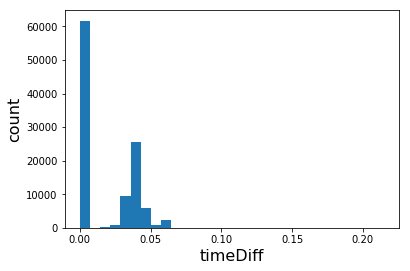

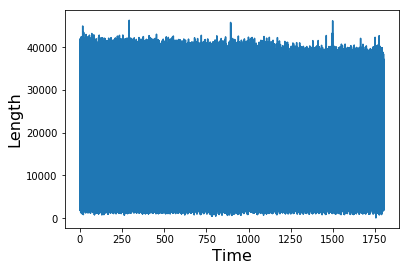

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from math import ceil
import timeit

time_slice = 10; #in seconds
num_labels = 3;
num_dfs_tot = 0
labels_dfs = [0]*num_labels

#to read multiple CSVs automatically
import glob
path = r'C:\Desktop stuff\university\camera captures\hik pcaps n CSVs' 
allFolderPaths = glob.glob(path + "/*")


#TODO: read all CSVs for label i, and cut 15 sec of start and end of each video. remove outliers.
for i in range(num_labels) :
    labels_dfs[i] = [pd.read_csv(f) for f in glob.glob(allFolderPaths[i] + "/*.csv")]
    num_dfs_tot += len(labels_dfs[i])

    for j in range(len(labels_dfs[i])) :
        labels_dfs[i][j] = labels_dfs[i][j][labels_dfs[i][j].Time > 15]
        labels_dfs[i][j] = labels_dfs[i][j][labels_dfs[i][j].Time < labels_dfs[i][j]["Time"].iloc[-1] - 15]
        labels_dfs[i][j]['Time'] -= 15
        labels_dfs[i][j]['Label'] = i

#%% Find the Time diff that shows when a frame ends

combined = pd.DataFrame()

seconds_in_DFs_list = [0]*num_dfs_tot #in a every single video dataframe
time_slice_list     = [0]*num_dfs_tot #initiallization
indexes_to_split_frame_by_list = [0]*num_dfs_tot #initiallization
time_sliced_df_list = []


start = timeit.default_timer() #to measure runtime

for k in range(num_labels) : #slice data frames by time slice seconds
    for i in list(range(len(labels_dfs[k]))) : #slice data frames by time slice seconds
        #"lose" non essential data
       labels_dfs[k][i].drop(['Source' , 'Destination' , 'Protocol' , 'Info' , 'No.'], axis=1, inplace=True)
       labels_dfs[k][i]['Time']  = labels_dfs[k][i]['Time'].astype('float') #change Time column data to int type 
        
        
        
        
        
        
        
        
        
        
        
       combined = combined.append(labels_dfs[k][i])
       
       seconds_in_DFs_list[i] = int(ceil(labels_dfs[k][i].at[len(labels_dfs[k][i])-1,'Time'])) #number of seconds in current df
       time_slice_list[i] = list(range(0,seconds_in_DFs_list[i],time_slice)) #list of times to slice by
       indexes_to_split_frame_by_list[i] = list(range(0,seconds_in_DFs_list[i],time_slice)) #initialization
       
       for j in list(range(len(time_slice_list[i]))): #calc indexes to slice by
           #find first index of labels_dfs[k][i]['Time'] the exceeds time_slice_list[i][j]
           indexes_to_split_frame_by_list[i][j] = np.argmax(labels_dfs[k][i]['Time'] > time_slice_list[i][j]) -1 #TODO: moved below.
                
       df_slice = pd.DataFrame() 
       
       for j in list(range(len(time_slice_list[i]))): #TODO: change for efficiency.
           #print(len(time_slice_list[i]))
           #indexes_to_split_frame_by_list[i][j] = np.argmax(labels_dfs[k][i]['Time'] > time_slice_list[i][j]) -1 TODO: doesnt work because we need j+1.
           if (j != len(time_slice_list[i])-1 and j != 0):  #not first or last index
               ind_start = indexes_to_split_frame_by_list[i][j] + 1
               ind_end = indexes_to_split_frame_by_list[i][j+1] + 1
           elif j == len(time_slice_list[i])-1:             #last index
               ind_start = indexes_to_split_frame_by_list[i][j] + 1
               ind_end = len(labels_dfs[k][i])
           else:                                            # j==0, first index
               ind_start = 0
               ind_end = indexes_to_split_frame_by_list[i][j+1]+1
           
           df_slice = labels_dfs[k][i][ind_start:ind_end]
           df_slice.loc[:,'Time'] = df_slice['Time'].diff().fillna(0) #calc time diffs, not time since begining of recording packets.
           time_sliced_df_list.append(df_slice)
         

combined.to_csv('combined.csv',index=False)










#%%

timeDiffCol = labels_dfs[1][1]['Time']
# timeDiffCol = timeDiffCol.diff().fillna(0) #calc time diffs, not time since begining of recording packets.
import matplotlib.pyplot as plt
plt.figure()
plt.hist(timeDiffCol, bins = 30)
plt.xlabel('timeDiff', fontsize=16); plt.ylabel('count', fontsize=16)


#%% Distinguish between the frames

labels_dfs[1][1]['frameNum'] = 0
j=0
timeDiffCol.reset_index(drop = True , inplace = True)
labels_dfs[1][1].reset_index(drop = True ,inplace = True)

#for i in range(len(timeDiffCol)) :
#   labels_dfs[1][1]['frameNum'] = j
#   if(timeDiffCol[i] >= 0.025) : 
#       j += 1

#labels_dfs[1][1].iterrows()

import time
t0 = time.time()
for idx,row in labels_dfs[1][1].iterrows():
#    labels_dfs[1][1]['frameNum'] = j
    if(timeDiffCol[idx] < 0.025) : 
        labels_dfs[1][1].at[idx,'frameNum'] = j
    else:
        j += 1
        labels_dfs[1][1].at[idx,'frameNum'] = j
#        print(j)
print ('time:  ', time.time()-t0)


plt.figure()
united = labels_dfs[1][1].groupby('frameNum',axis=0).sum()
united['Time'] = np.cumsum(united['Time'])

plt.plot(united['Time'],united['Length'])
plt.xlabel('Time', fontsize=16); plt.ylabel('Length', fontsize=16)



# frames first vids to train, last vids to test


len 0 134929
len 1 115942
len 2 115107


C:\Users\wnp387\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:150: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


accuracy_score: 0.30
mean_absolute_error: 0.754


RunTime: 75.52257409999999 sec
Normalized confusion matrix


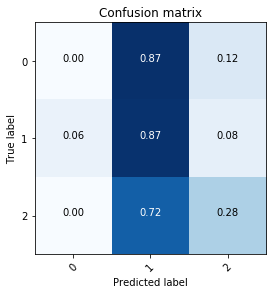

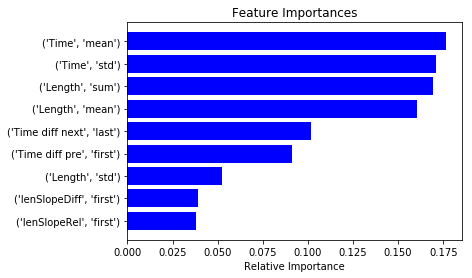

In [3]:

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from math import ceil
import timeit
from skimage import filters
import matplotlib.pyplot as plt

num_labels = 3;
num_dfs_tot = 0
labels_dfs = [0]*num_labels
thresholds = [0]*num_labels
combined_DF= pd.DataFrame()

#to read multiple CSVs automatically
import glob
path = r'C:\Desktop stuff\university\camera captures\hik pcaps n CSVs' 
allFolderPaths = glob.glob(path + "/*")


timeDiffCol = pd.Series()
n=0
start = timeit.default_timer() #to measure runtime

for i in range(num_labels) :
    labels_dfs[i] = [pd.read_csv(f) for f in glob.glob(allFolderPaths[i] + "/*.csv")]
    num_dfs_tot += len(labels_dfs[i])
    thresholds[i] = [0]*len(labels_dfs[i])
    
    for j in range(len(labels_dfs[i])) :
        labels_dfs[i][j].drop(['Source' , 'Destination' , 'Protocol' , 'Info' , 'No.'], axis=1, inplace=True)
        labels_dfs[i][j] = labels_dfs[i][j][labels_dfs[i][j].Time > 15]
        labels_dfs[i][j] = labels_dfs[i][j][labels_dfs[i][j].Time < labels_dfs[i][j]["Time"].iloc[-1] - 15]
        labels_dfs[i][j]['Time'] -= 15
        labels_dfs[i][j]['Label'] = i
        labels_dfs[i][j]['vidNum'] = j

        labels_dfs[i][j].loc[:,'Time'] = labels_dfs[i][j]['Time'].diff().fillna(0) #calc time diffs, not time since begining of recording packets.
        thresholds[i][j] = filters.threshold_otsu(labels_dfs[i][j]['Time'],nbins=30)
        df_size = len(labels_dfs[i][j])
        
        for idx,row in labels_dfs[i][j].iterrows():

            if(labels_dfs[i][j].at[idx,'Time'] < thresholds[i][j]) : 
                labels_dfs[i][j].at[idx,'frameNum'] = n
            else:
                n += 1
                labels_dfs[i][j].at[idx,'frameNum'] = n
                labels_dfs[i][j].at[idx,'Time diff pre'] = labels_dfs[i][j].at[idx,'Time']
                labels_dfs[i][j].at[idx,'lenSlopeDiff'] = labels_dfs[i][j].at[idx,'Length']-labels_dfs[i][j].at[idx-1,'Length']
                labels_dfs[i][j].at[idx,'lenSlopeRel'] = labels_dfs[i][j].at[idx,'Length']/labels_dfs[i][j].at[idx-1,'Length']
                labels_dfs[i][j].at[idx-1,'Time diff next'] = labels_dfs[i][j].at[idx,'Time']

        
        combined_DF = pd.concat([combined_DF , labels_dfs[i][j]])

united = combined_DF.groupby('frameNum' ,sort = 'False').agg({'Time': ['std' ,'mean'],
                                                                  'Length' : ['std' , 'mean' , 'sum'],
                                                                  'Label' : 'first',
                                                                  'Time diff pre':'first',
                                                                  'Time diff next' : 'last',
                                                                  'lenSlopeDiff' : 'first',
                                                                  'lenSlopeRel' : 'first',
                                                                  'vidNum' : 'first'}).fillna(0)
#united = united.sample(frac=1, random_state =1).reset_index(drop=True) #mix the data!!!

#united = united.infer_objects() #convert all data types in DF to numeric

#%%
train_labels  = pd.DataFrame()
test_labels  = pd.DataFrame()
train_data = pd.DataFrame()
test_data = pd.DataFrame()


#print('\nlen of united with I frames:', len(united))
#united.drop(np.where((united['Length','sum']>13000) == True)[0], axis=0, inplace=True)
#united.reset_index(drop=True)
#print('len of united withot I frames:', len(united))

j=0
for i in range(num_labels) :
    label_len = len(np.where(united['Label'] == i)[0])
    single_mixed_label = united[j:j+label_len-1].reset_index(drop=True)
#    print('len mixed label', len(single_mixed_label))

    print('len',i,label_len)
    len_all_but_1_vid = len(single_mixed_label) - len(np.where(single_mixed_label['vidNum']==2)[0])
#    print('len vid num2',len(np.where(single_mixed_label['vidNum']==2)[0]))
#    print('len_all_but_1_vid',len_all_but_1_vid)

#    train_labels = pd.concat([train_labels,single_mixed_label[0: (int)(label_len*0.8)]['Label']], axis=0) #first 80% of data for label i
    train_data = pd.concat([train_data,single_mixed_label[0: len_all_but_1_vid]], axis=0) #first 80% of data for label i
#    test_labels = pd.concat([test_labels,single_mixed_label[(int)(label_len*0.8):]['Label']], axis=0) #first 80% of data for label i
    test_data = pd.concat([test_data,single_mixed_label[len_all_but_1_vid+1:]], axis=0) #first 80% of data for label i
#    print('len of 20 per single_mixed_label', len(single_mixed_label[len_all_but_1_vid:]) ,(int)(label_len*0.2) )
#    print('j:', j)

    j+= label_len
    
#train_data = []
#test_data = []
#for i in range(num_labels) :
#    single_label_df = final_df[final_df.label == i]
#    single_label_df = single_label_df.sample(frac=1).reset_index(drop=True) #mix the data!!!
#    train_data.append(single_label_df[:int(len(single_label_df)*0.8)]) #first 80% of data
#    test_data.append(single_label_df[int(len(single_label_df)*0.8):])  #last 20% of data

#united = united.sample(frac=1, random_state =1).reset_index(drop=True) #mix the data!!!

train_data = train_data.sample(frac=1, random_state =1).reset_index(drop=True) #mix the data!!!
test_data = test_data.sample(frac=1, random_state =1).reset_index(drop=True) #mix the data!!!
train_labels = train_data['Label']
test_labels = test_data['Label']



#train_data  = pd.concat([united[:int(len(united)*0.8)]], axis=0) #first 80% of data for label i
#test_data   = pd.concat([united[int(len(united)*0.8):]], axis=0)   #last 20% of data for label i
    
#%%
#train_data = train_data.sample(frac=1).reset_index(drop=True) #mix the data!!!
#test_data  = test_data.sample(frac=1).reset_index(drop=True) #mix the data!!!
#train_labels = train_data['Label'] #get labels
#test_labels = test_data['Label'] #get labels
train_data.drop(['Label','vidNum'],axis=1, inplace=True) #remove labels from data
test_data.drop(['Label','vidNum'],axis=1, inplace=True) #remove labels from data





#from scipy import stats #clear outliers!!!
#zscore = np.abs(stats.zscore(final_df.drop('label',axis=1))) # clear outliers from every label's DF
#final_df = final_df[(zscore < 3).all(axis=1)] # 95% of valid data! - 3 STDs from normal distr.
#
#
#labels = final_df['label'] #get labels
#final_df = final_df.drop('label',axis=1) #remove labels from data
#
#train_data = final_df[:int(len(final_df)*0.8)] #first 80% of data
#train_labels = labels[:int(len(final_df)*0.8)].astype('int') #first 80% of labels
#test_data = final_df[int(len(final_df)*0.8):]  #last 20% of data
#test_labels = labels[int(len(final_df)*0.8):].astype('int') #last 20% of labels

clf = RandomForestClassifier()
clf.fit(train_data ,train_labels)
pred = clf.predict(test_data)

acc_score = "{:.2f}".format(accuracy_score(test_labels , pred))
mean_absolute_err = "{:.3f}".format(mean_absolute_error(test_labels , pred))

print ('accuracy_score:',acc_score) #, '.time_slice:', time_slice, 'sec')
print ('mean_absolute_error:', mean_absolute_err) #, '.time_slice:', time_slice,'sec')

#TODO: AUC ROC curve 

stop = timeit.default_timer()
print('\n\nRunTime:', stop - start, 'sec')

#%%

import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(true_class, prediction,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = confusion_matrix(true_class, prediction) # HERE YA VICTOR
    classes = (np.sort(np.unique(true_class)))
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

   # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    plt.show()
    
    return


plt.figure()
plot_confusion_matrix(test_labels, pred)

#%%

features = list(train_data.columns.values)
importances = clf.feature_importances_
indices = np.argsort(importances)

plt.figure()

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# frame test

Text(0,0.5,'mean packet len')

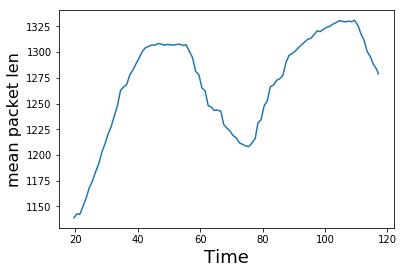

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
PATHTOFILE = r'C:\Desktop stuff\university\camera captures\frame_test.csv'
df = pd.read_csv(PATHTOFILE)

df['key'] = np.array(df['Time']).astype(int)

df = df.groupby('key',axis=0).mean()

#VR_funcs.PlotXYZ(df['Time'], df['Length'], [1]*len(df['Time']))
df['Length'] = df['Length'].rolling(20).mean()

plt.figure()
plt.plot(df['Time'], df['Length'])
plt.xlabel('Time', fontsize=18); plt.ylabel('mean packet len', fontsize=16)

time:   0.6802127361297607


ValueError: 
    Invalid value of type 'numpy.int32' received for the 'name' property of scatter
        Received value: 1

    The 'name' property is a string and must be specified as:
      - A string
      - A number that will be converted to a string

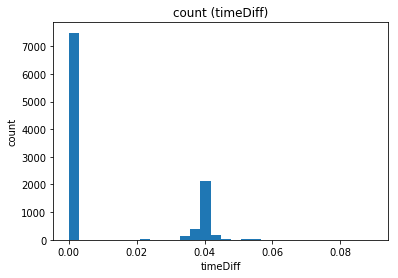

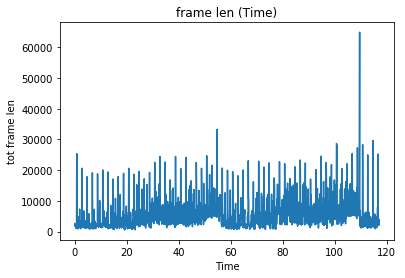

In [5]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import VR_funcs
PATHTOFILE = r'C:\Desktop stuff\university\camera captures\frame_test.csv'
df = pd.read_csv(PATHTOFILE)

#%%
#df['key'] = np.array(df['Time']).astype(int)
#
#df = df.groupby('key',axis=0).mean()
#
##VR_funcs.PlotXYZ(df['Time'], df['Length'], [1]*len(df['Time']))
#df['Length'] = df['Length'].rolling(20).mean()
#
#plt.figure(1)
#plt.plot(df['Time'], df['Length'])
#plt.xlabel('Time', fontsize=18); plt.ylabel('mean packet len', fontsize=16)



#%% Distinguish between the frames

df['frameNum'] = 0
j=0

timeDiffCol = df.loc[:,'Time'] = df['Time'].diff().fillna(0) #calc time diffs, not time since begining of recording packets.
timeDiffCol.reset_index(drop = True , inplace = True)


#%%
plt.figure()
plt.hist(timeDiffCol, bins = 30)
plt.title('count (timeDiff)'); plt.xlabel('timeDiff'); plt.ylabel('count')

#%%
#labels_dfs[1][1].reset_index(drop = True ,inplace = True)

#for i in range(len(timeDiffCol)) :
#   labels_dfs[1][1]['frameNum'] = j
#   if(timeDiffCol[i] >= 0.025) : 
#       j += 1

#labels_dfs[1][1].iterrows()

import time
t0 = time.time()
for idx,row in df.iterrows():
#    labels_dfs[1][1]['frameNum'] = j
    if(timeDiffCol[idx] < 0.038) : 
        df.at[idx,'frameNum'] = j
    else:
        j += 1
        df.at[idx,'frameNum'] = j
#        print(j)
print ('time:  ', time.time()-t0)


united = df.groupby('frameNum',axis=0).sum()
united['Time'] = np.cumsum(united['Time'])

#united[united['Length'] < 15000] = 0

plt.figure()
plt.title('frame len (Time)'); plt.xlabel('Time'); plt.ylabel('tot frame len')
plt.plot(united['Time'],united['Length'])

#%%
from VR_funcs import *
VR_funcs.PlotXYZ(x=united.Time, y=united.Length, z=[1]*len(united),name='drek.html')